In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import display
import torchvision.models as models

import itertools
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.cuda.amp import autocast

from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.cuda.amp import autocast, GradScaler

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
data = pd.read_csv('../data/synthetic_with_missing.csv')
data.head()

,A_1,X_1,Y_1,Z_1,t_1,A_2,X_2,Y_2,Z_2,t_2,...,Y_35,Z_35,t_35,A_36,X_36,Y_36,Z_36,t_36,theta,phi
0,1.0,-25.359,5.885,-6.684,78.875263,1.0,-37.609,5.885,-6.684,74.805427,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,100.0
1,1.0,-25.359,5.885,-6.684,78.359649,1.0,-37.609,5.885,-6.684,73.887611,...,-39.545,-7.339,-1.0,1.0,-25.359,-39.545,-7.279,165.307207,35.0,101.0
2,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,102.0
3,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,103.0
4,-1.0,-25.359,5.885,-6.684,-1.000000,-1.0,-37.609,5.885,-6.684,-1.000000,...,-39.545,-7.339,-1.0,-1.0,-25.359,-39.545,-7.279,-1.000000,35.0,104.0


In [5]:
X = data.drop(columns=['theta', 'phi']).values
y = data[['theta']].values

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

In [28]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(
    y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(
    y_test, dtype=torch.float32).view(-1, 1).to(device)

In [29]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [31]:
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

In [32]:
input_dim = X_train.shape[1]
model = RegressionModel(input_dim).to(device)

In [34]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Training Progress: 100%|█| 100/100 [00:30<00:00,  3.25it/s, test_loss=102.7925, train_loss=100.3014]


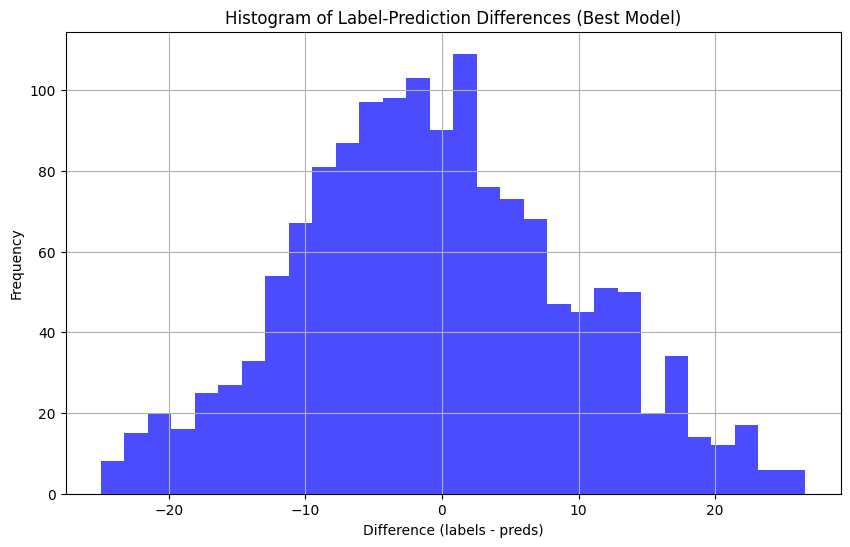

In [ ]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

num_epochs = 100

best_model_weights = None
best_test_loss = float('inf')

outer_progress = tqdm(
    total=num_epochs, desc="Training Progress", ncols=100, position=0, leave=True)

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = epoch_loss / len(train_loader)

    model.eval()
    test_loss = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch = X_test_batch.to(device).float()
            y_test_batch = y_test_batch.to(device).float()

            preds = model(X_test_batch)
            test_loss += criterion(preds, y_test_batch).item()

            all_labels.append(y_test_batch.cpu())
            all_preds.append(preds.cpu())

    avg_test_loss = test_loss / len(test_loader)

    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        best_model_weights = model.state_dict()
        best_labels = torch.cat(all_labels)
        best_preds = torch.cat(all_preds)

    outer_progress.set_postfix(
        train_loss=f"{avg_train_loss:.4f}", test_loss=f"{avg_test_loss:.4f}")
    outer_progress.update(1)

outer_progress.close()

model.load_state_dict(best_model_weights)

plt.figure(figsize=(10, 6))
plt.hist((best_labels - best_preds).numpy(), bins=30, alpha=0.7, color='blue')
plt.title('Histogram of Label-Prediction Differences (Best Model)')
plt.xlabel('Difference (labels - preds)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()